# Python: IRM and APO Model Comparison

In this simple example, we illustrate how the (binary) [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#binary-interactive-regression-model-irm) model and the [DoubleMLAPOS](https://docs.doubleml.org/stable/guide/models.html#average-potential-outcomes-apos-for-multiple-treatment-levels) differ.

More specifically, we focus on the `causal_contrast()` method of [DoubleMLAPOS](https://docs.doubleml.org/stable/guide/models.html#average-potential-outcomes-apos-for-multiple-treatment-levels) in a binary setting to highlight, when both methods coincide.

In [4]:
import numpy as np
import pandas as pd
import doubleml as dml

from sklearn.linear_model import LinearRegression, LogisticRegression

from doubleml.datasets import make_irm_data

## Data

We rely on the [make_irm_data](https://docs.doubleml.org/stable/api/generated/doubleml.datasets.make_irm_data.html) go generate data with a binary treatment.

In [5]:
n_obs = 2000

np.random.seed(42)
df = make_irm_data(
    n_obs=n_obs,
    dim_x=10,
    theta=5.0,
    return_type='DataFrame'
)

df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y,d
0,0.541060,0.195963,0.835750,1.180271,0.655959,1.044239,-1.214769,-2.160836,-2.196655,-2.037529,4.704558,1.0
1,1.340235,2.319420,2.193375,1.139508,1.458814,0.493195,1.313870,0.127337,0.418400,1.070433,6.113952,1.0
2,-0.563563,-1.480199,0.943548,-0.400113,0.757559,0.131483,-0.574160,0.067212,-0.427654,-1.342117,-0.226479,0.0
3,-0.044176,-2.122421,-1.526582,-1.892828,-1.777867,-1.425325,0.020272,0.487524,-0.579197,-0.752909,0.367366,0.0
4,-1.896263,-1.198493,-1.285483,-1.361623,-2.921778,-2.026966,-1.107156,-0.498122,0.568287,1.004542,0.913585,0.0


First, define the ``DoubleMLData`` object.

In [6]:
dml_data = dml.DoubleMLData(
    df,
    y_col='y',
    d_cols='d'
)

## Learners and Hyperparameters

To simplify the comparison and keep the variation in learners as small as possible, we will use linear models.

In [7]:
n_folds = 5
n_rep = 1

dml_kwargs = {
    "obj_dml_data": dml_data,
    "ml_g": LinearRegression(),
    "ml_m": LogisticRegression(random_state=42),
    "n_folds": n_folds,
    "n_rep": n_rep,
    "normalize_ipw": True,
    "trimming_threshold": 1e-2,
    "draw_sample_splitting": False,
}

**Remark:**
All results rely on the exact same predictions for the machine learning algorithms. If the more than two treatment levels exists the `DoubleMLAPOS` model fit multiple binary models such that the combined model might differ.

Further, to remove all uncertainty from sample splitting, we will rely on externally provided sample splits.

In [8]:
from doubleml.utils import DoubleMLResampling

rskf = DoubleMLResampling(
    n_folds=n_folds,
    n_rep=n_rep,
    n_obs=n_obs,
    stratify=df['d'],
)
all_smpls = rskf.split_samples()

## Average Treatment Effect

Comparing the effect estimates for the `DoubleMLIRM` and `causal_contrasts` of the `DoubleMLAPOS` model, we can numerically equivalent results for the ATE.

In [9]:
dml_irm = dml.DoubleMLIRM(**dml_kwargs)
dml_irm.set_sample_splitting(all_smpls)
print("Training IRM Model")
dml_irm.fit()

print(dml_irm.summary)

Training IRM Model
       coef   std err          t  P>|t|     2.5 %    97.5 %
d  5.002585  0.066201  75.566262    0.0  4.872833  5.132337


In [10]:
dml_apos = dml.DoubleMLAPOS(treatment_levels=[0,1], **dml_kwargs)
dml_apos.set_sample_splitting(all_smpls)
print("Training APOS Model")
dml_apos.fit()
print(dml_apos.summary)

print("Evaluate Causal Contrast")
causal_contrast = dml_apos.causal_contrast(reference_levels=[0])
print(causal_contrast.summary)

Training APOS Model
       coef   std err           t     P>|t|     2.5 %    97.5 %
0  0.037800  0.045201    0.836262  0.403008 -0.050793  0.126392
1  5.040385  0.048482  103.965037  0.000000  4.945363  5.135407
Evaluate Causal Contrast
            coef   std err          t  P>|t|     2.5 %    97.5 %
1 vs 0  5.002585  0.066201  75.566262    0.0  4.872833  5.132337


For a direct comparison, see

In [11]:
print("IRM Model")
print(dml_irm.summary)
print("Causal Contrast")
print(causal_contrast.summary)

IRM Model
       coef   std err          t  P>|t|     2.5 %    97.5 %
d  5.002585  0.066201  75.566262    0.0  4.872833  5.132337
Causal Contrast
            coef   std err          t  P>|t|     2.5 %    97.5 %
1 vs 0  5.002585  0.066201  75.566262    0.0  4.872833  5.132337


## Average Treatment Effect on the Treated

For the average treatment effect on the treated we can adjust the score in `DoubleMLIRM` model to `score="ATTE"`.

In [12]:
dml_irm_atte = dml.DoubleMLIRM(score="ATTE", **dml_kwargs)
dml_irm_atte.set_sample_splitting(all_smpls)
print("Training IRM Model")
dml_irm_atte.fit()

print(dml_irm_atte.summary)

Training IRM Model
       coef   std err          t  P>|t|     2.5 %    97.5 %
d  5.541136  0.082383  67.260366    0.0  5.379668  5.702605


In order to consider weighted effects in the `DoubleMLAPOS` model, we have to specify the correct weight, see [User Guide](https://docs.doubleml.org/stable/guide/heterogeneity.html#weighted-average-treatment-effects).

As these weights include the propensity score, we will use the predicted propensity score from the previous `DoubleMLIRM` model.


In [13]:
p_hat = df["d"].mean()
m_hat = dml_irm_atte.predictions["ml_m"][:, :, 0]

weights_dict = {
    "weights": df["d"] / p_hat,
    "weights_bar": m_hat / p_hat,
}

dml_apos_atte = dml.DoubleMLAPOS(treatment_levels=[0,1], weights=weights_dict, **dml_kwargs)
dml_apos_atte.set_sample_splitting(all_smpls)
print("Training APOS Model")
dml_apos_atte.fit()
print(dml_apos_atte.summary)

print("Evaluate Causal Contrast")
causal_contrast_atte = dml_apos_atte.causal_contrast(reference_levels=[0])
print(causal_contrast_atte.summary)

Training APOS Model
       coef   std err           t     P>|t|     2.5 %    97.5 %
0  0.044364  0.072137    0.615000  0.538555 -0.097022  0.185751
1  5.585498  0.040281  138.663329  0.000000  5.506548  5.664447
Evaluate Causal Contrast
            coef   std err          t  P>|t|     2.5 %    97.5 %
1 vs 0  5.541133  0.082736  66.974012    0.0  5.378975  5.703292


The point estimates are equal but on closer comparison the standard errors and confidence intervals are larger in the causal contrast example.

In [14]:
dml_irm_weighted_atte = dml.DoubleMLIRM(score="ATE", weights=weights_dict, **dml_kwargs)
dml_irm_weighted_atte.set_sample_splitting(all_smpls)
print("Training IRM Model")
dml_irm_weighted_atte.fit()

print(dml_irm_weighted_atte.summary)

Training IRM Model
       coef   std err          t  P>|t|     2.5 %    97.5 %
d  5.541133  0.082736  66.974012    0.0  5.378975  5.703292


In summary, see

In [15]:
print("IRM Model ATTE Score")
print(dml_irm_atte.summary.round(4))
print("IRM Model (Weighted)")
print(dml_irm_weighted_atte.summary.round(4))
print("Causal Contrast (Weighted)")
print(causal_contrast_atte.summary.round(4))

IRM Model ATTE Score
     coef  std err        t  P>|t|   2.5 %  97.5 %
d  5.5411   0.0824  67.2604    0.0  5.3797  5.7026
IRM Model (Weighted)
     coef  std err       t  P>|t|  2.5 %  97.5 %
d  5.5411   0.0827  66.974    0.0  5.379  5.7033
Causal Contrast (Weighted)
          coef  std err       t  P>|t|  2.5 %  97.5 %
1 vs 0  5.5411   0.0827  66.974    0.0  5.379  5.7033


## Sensitivity Analysis

There exist also slight differences with respect to the bounds in the sensitivity analysis. 

In [16]:
dml_irm.sensitivity_analysis()
print(dml_irm.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
   CI lower  theta lower     theta  theta upper  CI upper
d  4.774269     4.891343  5.002585     5.113827  5.218325

------------------ Robustness Values ------------------
   H_0     RV (%)    RVa (%)
d  0.0  72.210512  66.247583


In [17]:
causal_contrast.sensitivity_analysis()
print(causal_contrast.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
        CI lower  theta lower     theta  theta upper  CI upper
1 vs 0  4.774269     4.891343  5.002585     5.113827  5.218325

------------------ Robustness Values ------------------
        H_0     RV (%)    RVa (%)
1 vs 0  0.0  72.210512  66.247583


## Effect Heterogeneity

In [47]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Assuming df is your DataFrame and df["X1"] is the column you want to transform
X = df[["X1"]]

# Create a PolynomialFeatures object with the desired degree
poly = PolynomialFeatures(degree=2, include_bias=True)

# Fit and transform the data
design_matrix = poly.fit_transform(X)

basis = pd.DataFrame(design_matrix, columns=poly.get_feature_names_out(["X1"]))

In [48]:
cate = dml_irm.cate(basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
          coef   std err          t         P>|t|    [0.025    0.975]
1     4.980006  0.065959  75.501036  0.000000e+00  4.850728  5.109284
X1    0.921124  0.072210  12.756191  2.879412e-37  0.779595  1.062653
X1^2  0.002328  0.042443   0.054851  9.562573e-01 -0.080859  0.085515


In [49]:
new_data = pd.DataFrame({"X1": np.linspace(np.quantile(df["X1"], 0.1), np.quantile(df["X1"], 0.9), 100)})

# Convert the result to a DataFrame with the same column names
grid_basis = pd.DataFrame( poly.transform(new_data), columns=poly.get_feature_names_out(["X1"]))

# Assuming cate is your model object that has a confint method
df_cate = cate.confint(grid_basis, level=0.95, joint=True, n_rep_boot=2000)
print(df_cate)

       2.5 %    effect    97.5 %
0   3.379763  3.803741  4.227719
1   3.410537  3.827810  4.245082
2   3.441103  3.851882  4.262661
3   3.471463  3.875957  4.280451
4   3.501623  3.900036  4.298449
..       ...       ...       ...
95  5.629324  6.104665  6.580006
96  5.641677  6.129040  6.616403
97  5.653741  6.153418  6.653095
98  5.665518  6.177799  6.690081
99  5.677011  6.202184  6.727356

[100 rows x 3 columns]


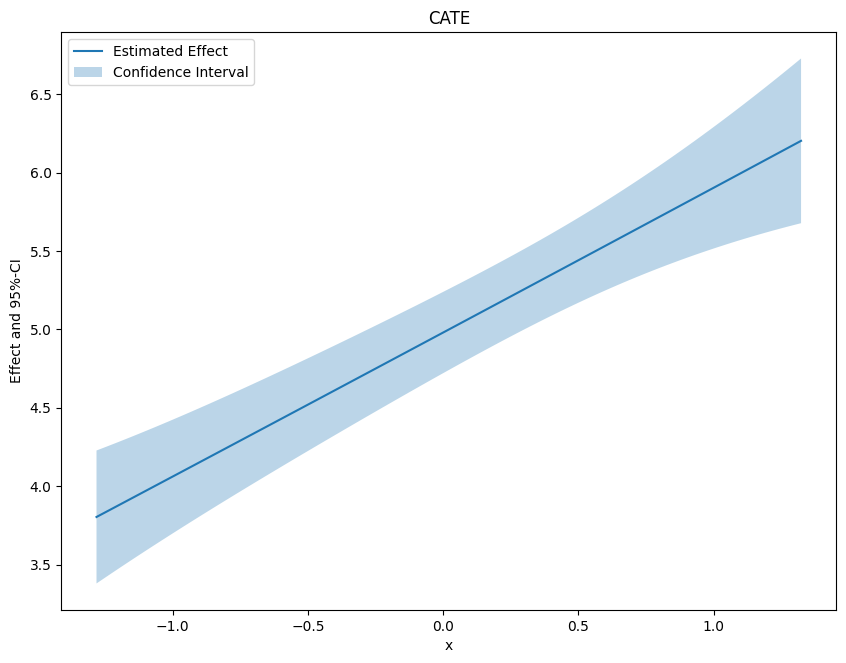

In [95]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

df_cate['x'] = new_data['X1']
fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], label='Estimated Effect')
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

In [58]:
capo0 = dml_apos.modellist[0].capo(basis)
print(capo0)
capo1 = dml_apos.modellist[1].capo(basis)
print(capo1)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
          coef   std err         t     P>|t|    [0.025    0.975]
1     0.013534  0.045659  0.296413  0.766915 -0.075956  0.103024
X1    0.001013  0.055947  0.018108  0.985553 -0.108641  0.110667
X1^2  0.023895  0.036482  0.654985  0.512477 -0.047608  0.095399
================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
          coef   std err           t         P>|t|    [0.025    0.975]
1     4.993540  0.047982  104.070731  0.000000e+00  4.899497  5.087583
X1    0.922137  0.045885   20.096828  7.866358e-90  0.832205  1.012070
X1^2  0.026223  0.022604    1.160093  2.460111e-01 -0.018081  0.070527


In [59]:
df_capo0 = capo0.confint(grid_basis, level=0.95, joint=True, n_rep_boot=2000)
df_capo1 = capo1.confint(grid_basis, level=0.95, joint=True, n_rep_boot=2000)

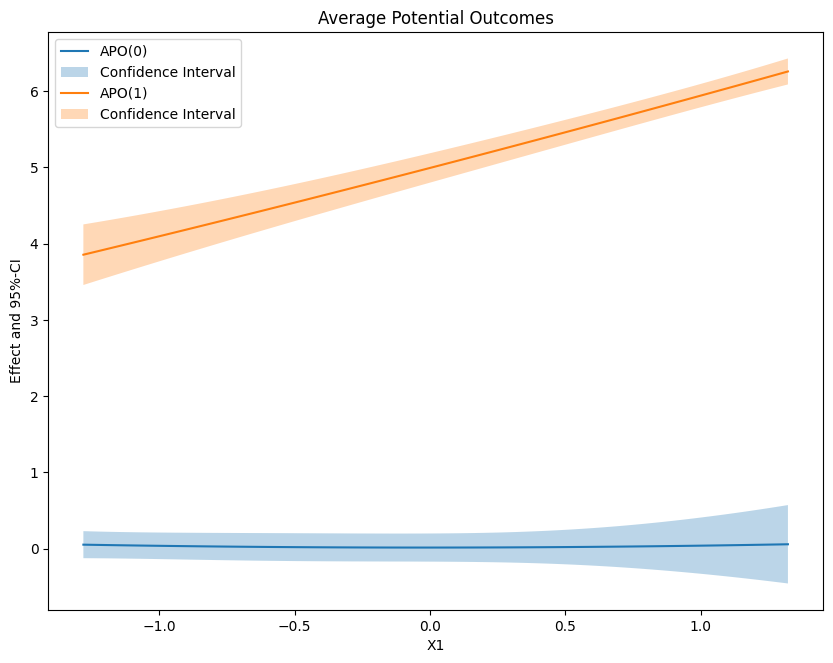

In [93]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

df_cate['x'] = new_data['X1']
fig, ax = plt.subplots()
ax.plot(df_cate['x'], df_capo0['effect'], label='APO(0)')
ax.fill_between(df_cate['x'], df_capo0['2.5 %'], df_capo0['97.5 %'], alpha=.3, label='Confidence Interval')

ax.plot(df_cate['x'], df_capo1['effect'], label='APO(1)')
ax.fill_between(df_cate['x'], df_capo1['2.5 %'], df_capo1['97.5 %'], alpha=.3, label='Confidence Interval')


plt.legend()
plt.title('Average Potential Outcomes')
plt.xlabel('X1')
_ =  plt.ylabel('Effect and 95%-CI')

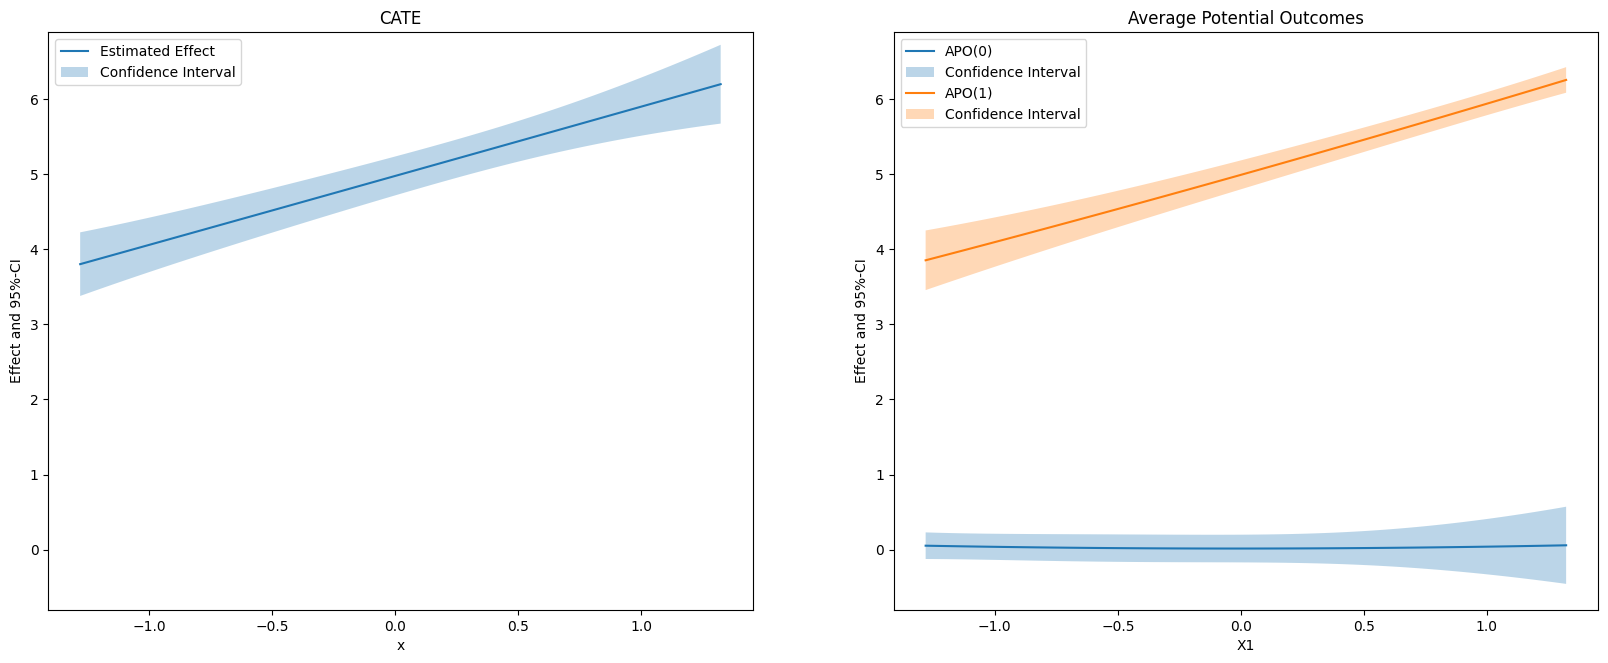

In [94]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 20., 7.5

df_cate['x'] = new_data['X1']

fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot CATE
ax1.plot(df_cate['x'], df_cate['effect'], label='Estimated Effect')
ax1.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], alpha=.3, label='Confidence Interval')
ax1.legend()
ax1.set_title('CATE')
ax1.set_xlabel('x')
ax1.set_ylabel('Effect and 95%-CI')

# Plot Average Potential Outcomes
ax2.plot(df_cate['x'], df_capo0['effect'], label='APO(0)')
ax2.fill_between(df_cate['x'], df_capo0['2.5 %'], df_capo0['97.5 %'], alpha=.3, label='Confidence Interval')
ax2.plot(df_cate['x'], df_capo1['effect'], label='APO(1)')
ax2.fill_between(df_cate['x'], df_capo1['2.5 %'], df_capo1['97.5 %'], alpha=.3, label='Confidence Interval')
ax2.legend()
ax2.set_title('Average Potential Outcomes')
ax2.set_xlabel('X1')
ax2.set_ylabel('Effect and 95%-CI')


# Ensure the same scale on y-axis
ax1.set_ylim(min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1]))
ax2.set_ylim(min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1]))

plt.show()

In [84]:
orth_signal = -1.0 * (causal_contrast.scaled_psi.reshape(-1) - causal_contrast.thetas)

causal_contrast_cate = dml.utils.DoubleMLBLP(orth_signal, basis)
causal_contrast_cate.fit()
df_causal_contrast_cate = causal_contrast_cate.confint(grid_basis, level=0.95, joint=True, n_rep_boot=2000)

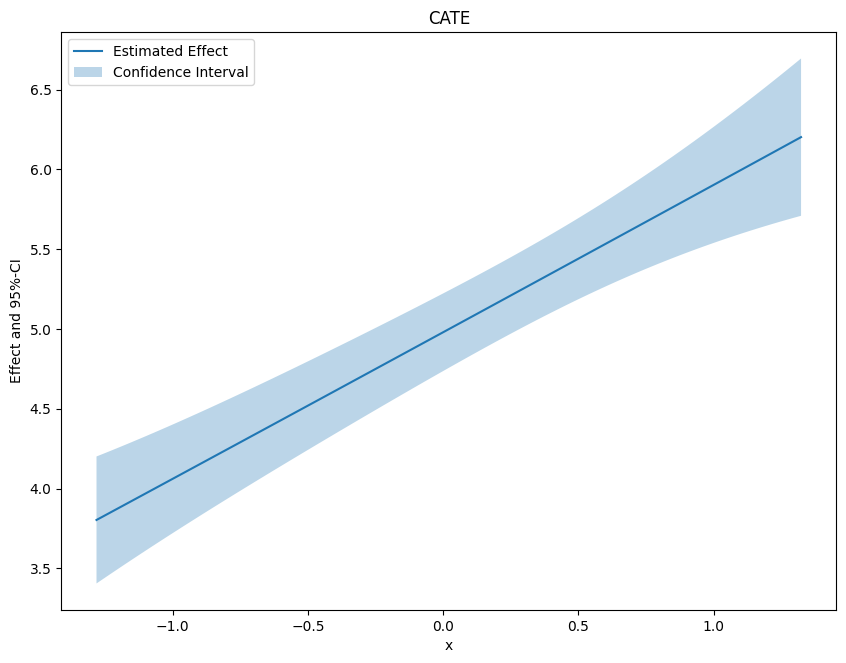

In [91]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

df_cate['x'] = new_data['X1']
fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_causal_contrast_cate['effect'], label='Estimated Effect')
ax.fill_between(df_cate['x'], df_causal_contrast_cate['2.5 %'], df_causal_contrast_cate['97.5 %'], alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

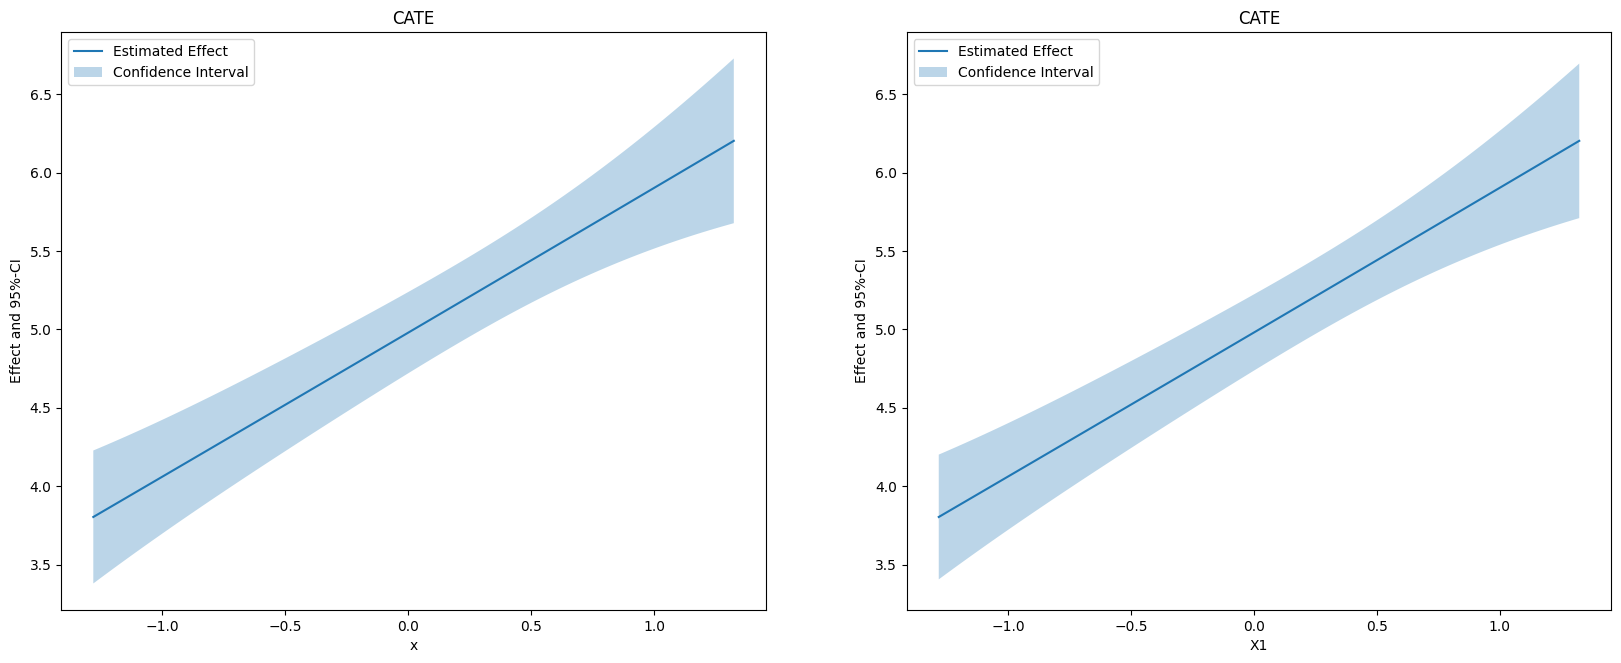

In [96]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 20., 7.5

df_cate['x'] = new_data['X1']

fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot CATE
ax1.plot(df_cate['x'], df_cate['effect'], label='Estimated Effect')
ax1.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], alpha=.3, label='Confidence Interval')
ax1.legend()
ax1.set_title('CATE')
ax1.set_xlabel('x')
ax1.set_ylabel('Effect and 95%-CI')

# Plot Average Potential Outcomes
ax2.plot(df_cate['x'], df_causal_contrast_cate['effect'], label='Estimated Effect')
ax2.fill_between(df_cate['x'], df_causal_contrast_cate['2.5 %'], df_causal_contrast_cate['97.5 %'], alpha=.3, label='Confidence Interval')
ax2.legend()
ax2.set_title('CATE')
ax2.set_xlabel('X1')
ax2.set_ylabel('Effect and 95%-CI')


# Ensure the same scale on y-axis
ax1.set_ylim(min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1]))
ax2.set_ylim(min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1]))

plt.show()